<a href="https://colab.research.google.com/github/Wayne-wyyking888/Stat-8931-GenAI/blob/main/chapter1/Chapter_I_Deep_Learning_Quick_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup and Packages load**

In [1]:
## package installation
! pip install accelerate datasets diffusers gym huggingface-hub ipykernel matplotlib numpy opencv-python pandas transformers
## Pytorch installation
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 # customized based on https://pytorch.org/get-started/locally/


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyar

## **In-Class Materials**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
import time

### (1). ResNet18 for CIFAR-10 data Claasification

In [3]:
def print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time):
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Time: {end_time - start_time}s')

def evaluate_model(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_pred

def visualize_predictions(images, predicted, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for ax, img, pred in zip(axes, images, predicted):
        img = img.permute(1, 2, 0)  # Convert from CxHxW to HxWxC for matplotlib
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[pred]}')
        ax.axis('off')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 170498071/170498071 [00:05<00:00, 33416166.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using cuda
Epoch 1, Loss: 1.173001813995259, Time: 64.8062117099762s
Epoch 2, Loss: 0.7055026774135087, Time: 57.56619620323181s


Accuracy: 0.7412


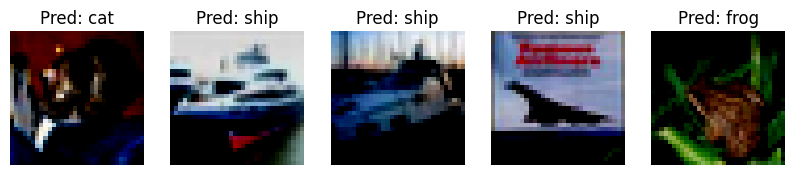

Epoch 3, Loss: 0.5251559876191342, Time: 53.589213848114014s
Epoch 4, Loss: 0.40210263087125997, Time: 58.569369316101074s


Accuracy: 0.8236


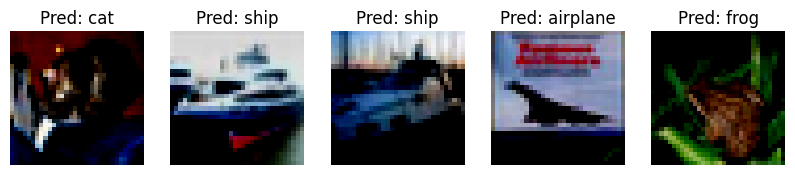

In [4]:
## training from the scratch
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Change the first conv layer
model.maxpool = nn.Identity()  # Omit max pooling
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for number of classes

# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, download=True, transform=transform),
    batch_size=5, shuffle=False)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Check for GPU availability and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = model.to(device)

# Training settings
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(4):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    end_time = time.time()
    print_epoch_stats(epoch, running_loss, train_loader, start_time, end_time)

    # Visualization every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            accuracy, _ = evaluate_model(model, device, test_loader)
            print(f'Accuracy: {accuracy}')

            images, labels = next(iter(test_loader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            images = images.cpu()
            visualize_predictions(images, predicted, class_names)


* Visulization With t-SNE (dimension reduction to 2D)


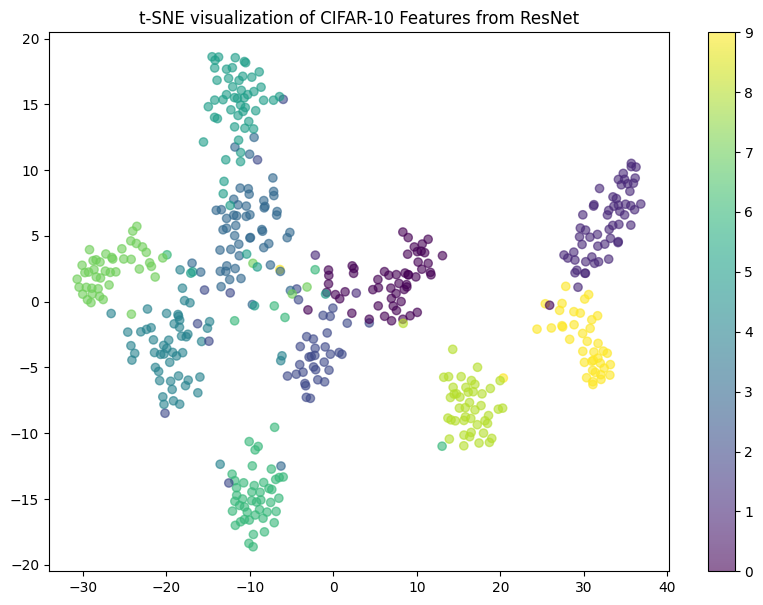

In [6]:
def extract_features_and_visualize(model, device, data_loader):
    # Modify the model to output features from the last layer before the fully connected layer
    model_modified = torch.nn.Sequential(*(list(model.children())[:-1]))
    model_modified = model_modified.to(device)

    # Extract features
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            output = model_modified(images)
            output = output.view(output.size(0), -1)  # Flatten the outputs
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # t-SNE transformation
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features[:500])  # Using subset for manageability

    # Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels[:500], cmap='viridis', alpha=0.6)

    plt.colorbar()
    plt.title('t-SNE visualization of CIFAR-10 Features from ResNet')
    plt.show()

# evaluate the earlier trained model
extract_features_and_visualize(model, device, train_loader)